In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
import optuna
import json
from utils import BikeDemandDataProcessor

plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [2]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("data/hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from C:\Users\Lawrence\Documents\PYTHON\bike_demand_2025/data/hour.csv


In [ ]:
test_period = 28*24

test_df = hour_processed_df[-test_period:]
test_df.to_csv("data/processed_data/test.csv", index=False)
train_df, val_df = processor.split_and_engineer_data(hour_processed_df[:-test_period])

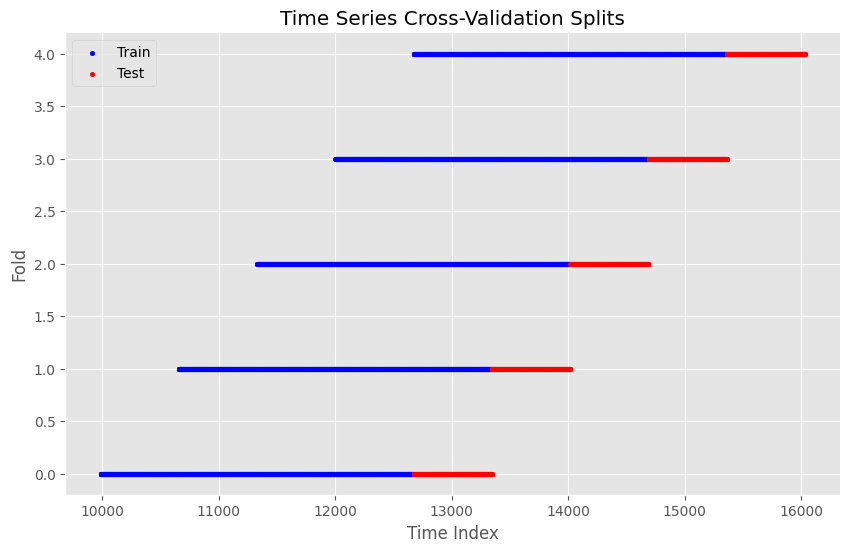

In [4]:
n_samples = len(train_df)

tcsv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=int(test_period / 0.2 * 0.8),
    test_size=int(test_period),
)

fig, ax = plt.subplots(figsize=(10, 6))

for i, (train_idx, test_idx) in enumerate(tcsv.split(np.arange(n_samples))):
    ax.scatter(train_idx, [i] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
    ax.scatter(test_idx, [i] * len(test_idx), color="red", label="Test" if i == 0 else "", s=10)

ax.set_xlabel("Time Index")
ax.set_ylabel("Fold")
ax.set_title("Time Series Cross-Validation Splits")
ax.legend()
sns.despine()
plt.show()

In [5]:
lambda_ = None

def func(x):
    global lambda_
    x = np.ravel(x)
    transformed, lambda_ = boxcox(x + 1)
    return transformed.reshape(-1, 1)

def inverse_func(x):
    global lambda_
    x = np.ravel(x)
    if lambda_ is None:
        raise ValueError("Lambda is not set. Call func() first.")
    if lambda_ == 0:
        return (np.exp(x) - 1).reshape(-1, 1)
    else:
        return ((x * lambda_ + 1) ** (1 / lambda_) - 1).reshape(-1, 1)

In [6]:
target = 'count'

with open('best_features_list.json', 'r') as f:
    features_from_rfe_selection = json.load(f)

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 
                   'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'hum_windspeed', 
                   'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 
                   'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 
                   'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 
                   'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'moonphase']

categorical_label_encode_columns = ['hour', 'year', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'working_day', 'weekend', 
                                    'is_monday', 'is_friday', 'christmas_holiday_season', 
                                    'summer_season', 'spring_season', 'fall_season', 'winter_season', 'is_night', 'rush_hour', 'is_business_hours', 'sigma_3_outlier']

categorical_one_hot_columns = ['quarter', 'day_of_week']

numeric_columns = [col for col in numeric_columns if col in features_from_rfe_selection]
categorical_label_encode_columns = [col for col in categorical_label_encode_columns if col in features_from_rfe_selection]
categorical_one_hot_columns = [col for col in categorical_one_hot_columns if col in features_from_rfe_selection]

features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns)  # Add one-hot encoding here
    ],
    remainder='drop',
    n_jobs=-1
)

X_train = train_df[features]
y_train = train_df[target]

In [7]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'num_leaves': trial.suggest_int('num_leaves', 30, 150, step=5),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0, step=0.05),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0, step=0.05),
        'random_state': 42,
        'verbose': -1
    }

    hour_processed_train_size_df = hour_processed_df.sort_values('timestamp').iloc[:int(len(hour_processed_df) * 0.8)]

    rmse_of_folds_list = []

    for train_idx, test_idx in tcsv.split(np.arange(len(hour_processed_train_size_df))):

        full_idx = np.concatenate((train_idx, test_idx))

        fold_df = hour_processed_train_size_df.iloc[full_idx]

        train_split, val_split = processor.split_and_engineer_data(fold_df)

        y_train_split = train_split['count']
        X_train_split = train_split[features_from_rfe_selection]

        y_val_split = val_split['count']
        X_val_split = val_split[features_from_rfe_selection]

        lgbm_regressor = lgb.LGBMRegressor(**params)

        transformed_regressor = TransformedTargetRegressor(
            regressor=lgbm_regressor,
            func=func,
            inverse_func=inverse_func
        )

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', transformed_regressor)
        ])

        pipe.fit(X_train_split, y_train_split)

        y_pred = pipe.predict(X_val_split)

        rmse_value = np.sqrt(mean_squared_error(y_val_split, y_pred))

        rmse_of_folds_list.append(rmse_value)

    return np.mean(rmse_of_folds_list)

study = optuna.create_study(direction='minimize')

n_trials = 500
study.optimize(objective, n_trials=n_trials)

with open('best_lgbm_params.json', 'w') as f:
    json.dump(study.best_params, f, indent=4)

print(f"Best parameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")


[I 2025-03-11 18:27:32,081] A new study created in memory with name: no-name-ba42d342-a9cd-4690-a7e5-3c0c47caf49b
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warni

Best parameters: {'n_estimators': 200, 'learning_rate': 0.08, 'max_depth': 4, 'num_leaves': 90, 'min_child_samples': 48, 'subsample': 0.75, 'colsample_bytree': 0.55, 'reg_alpha': 0.45, 'reg_lambda': 0.4}
Best RMSE: 69.39639898924685


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2

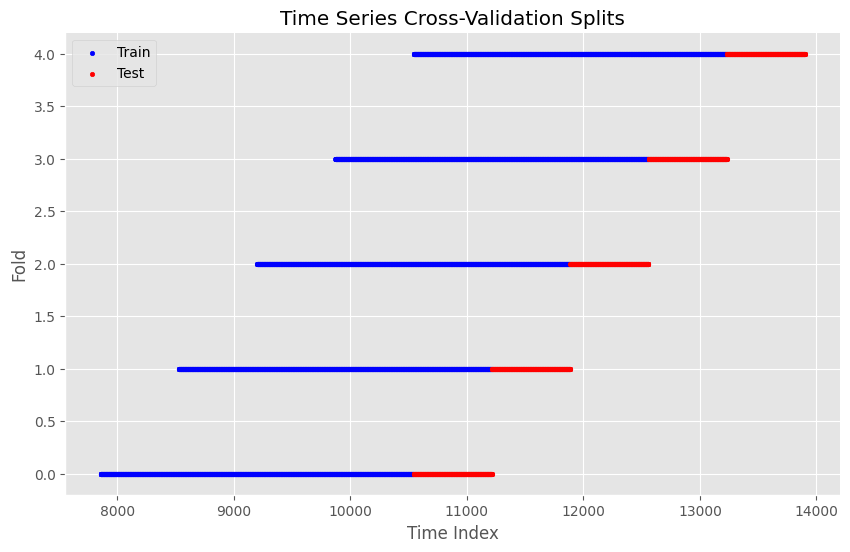

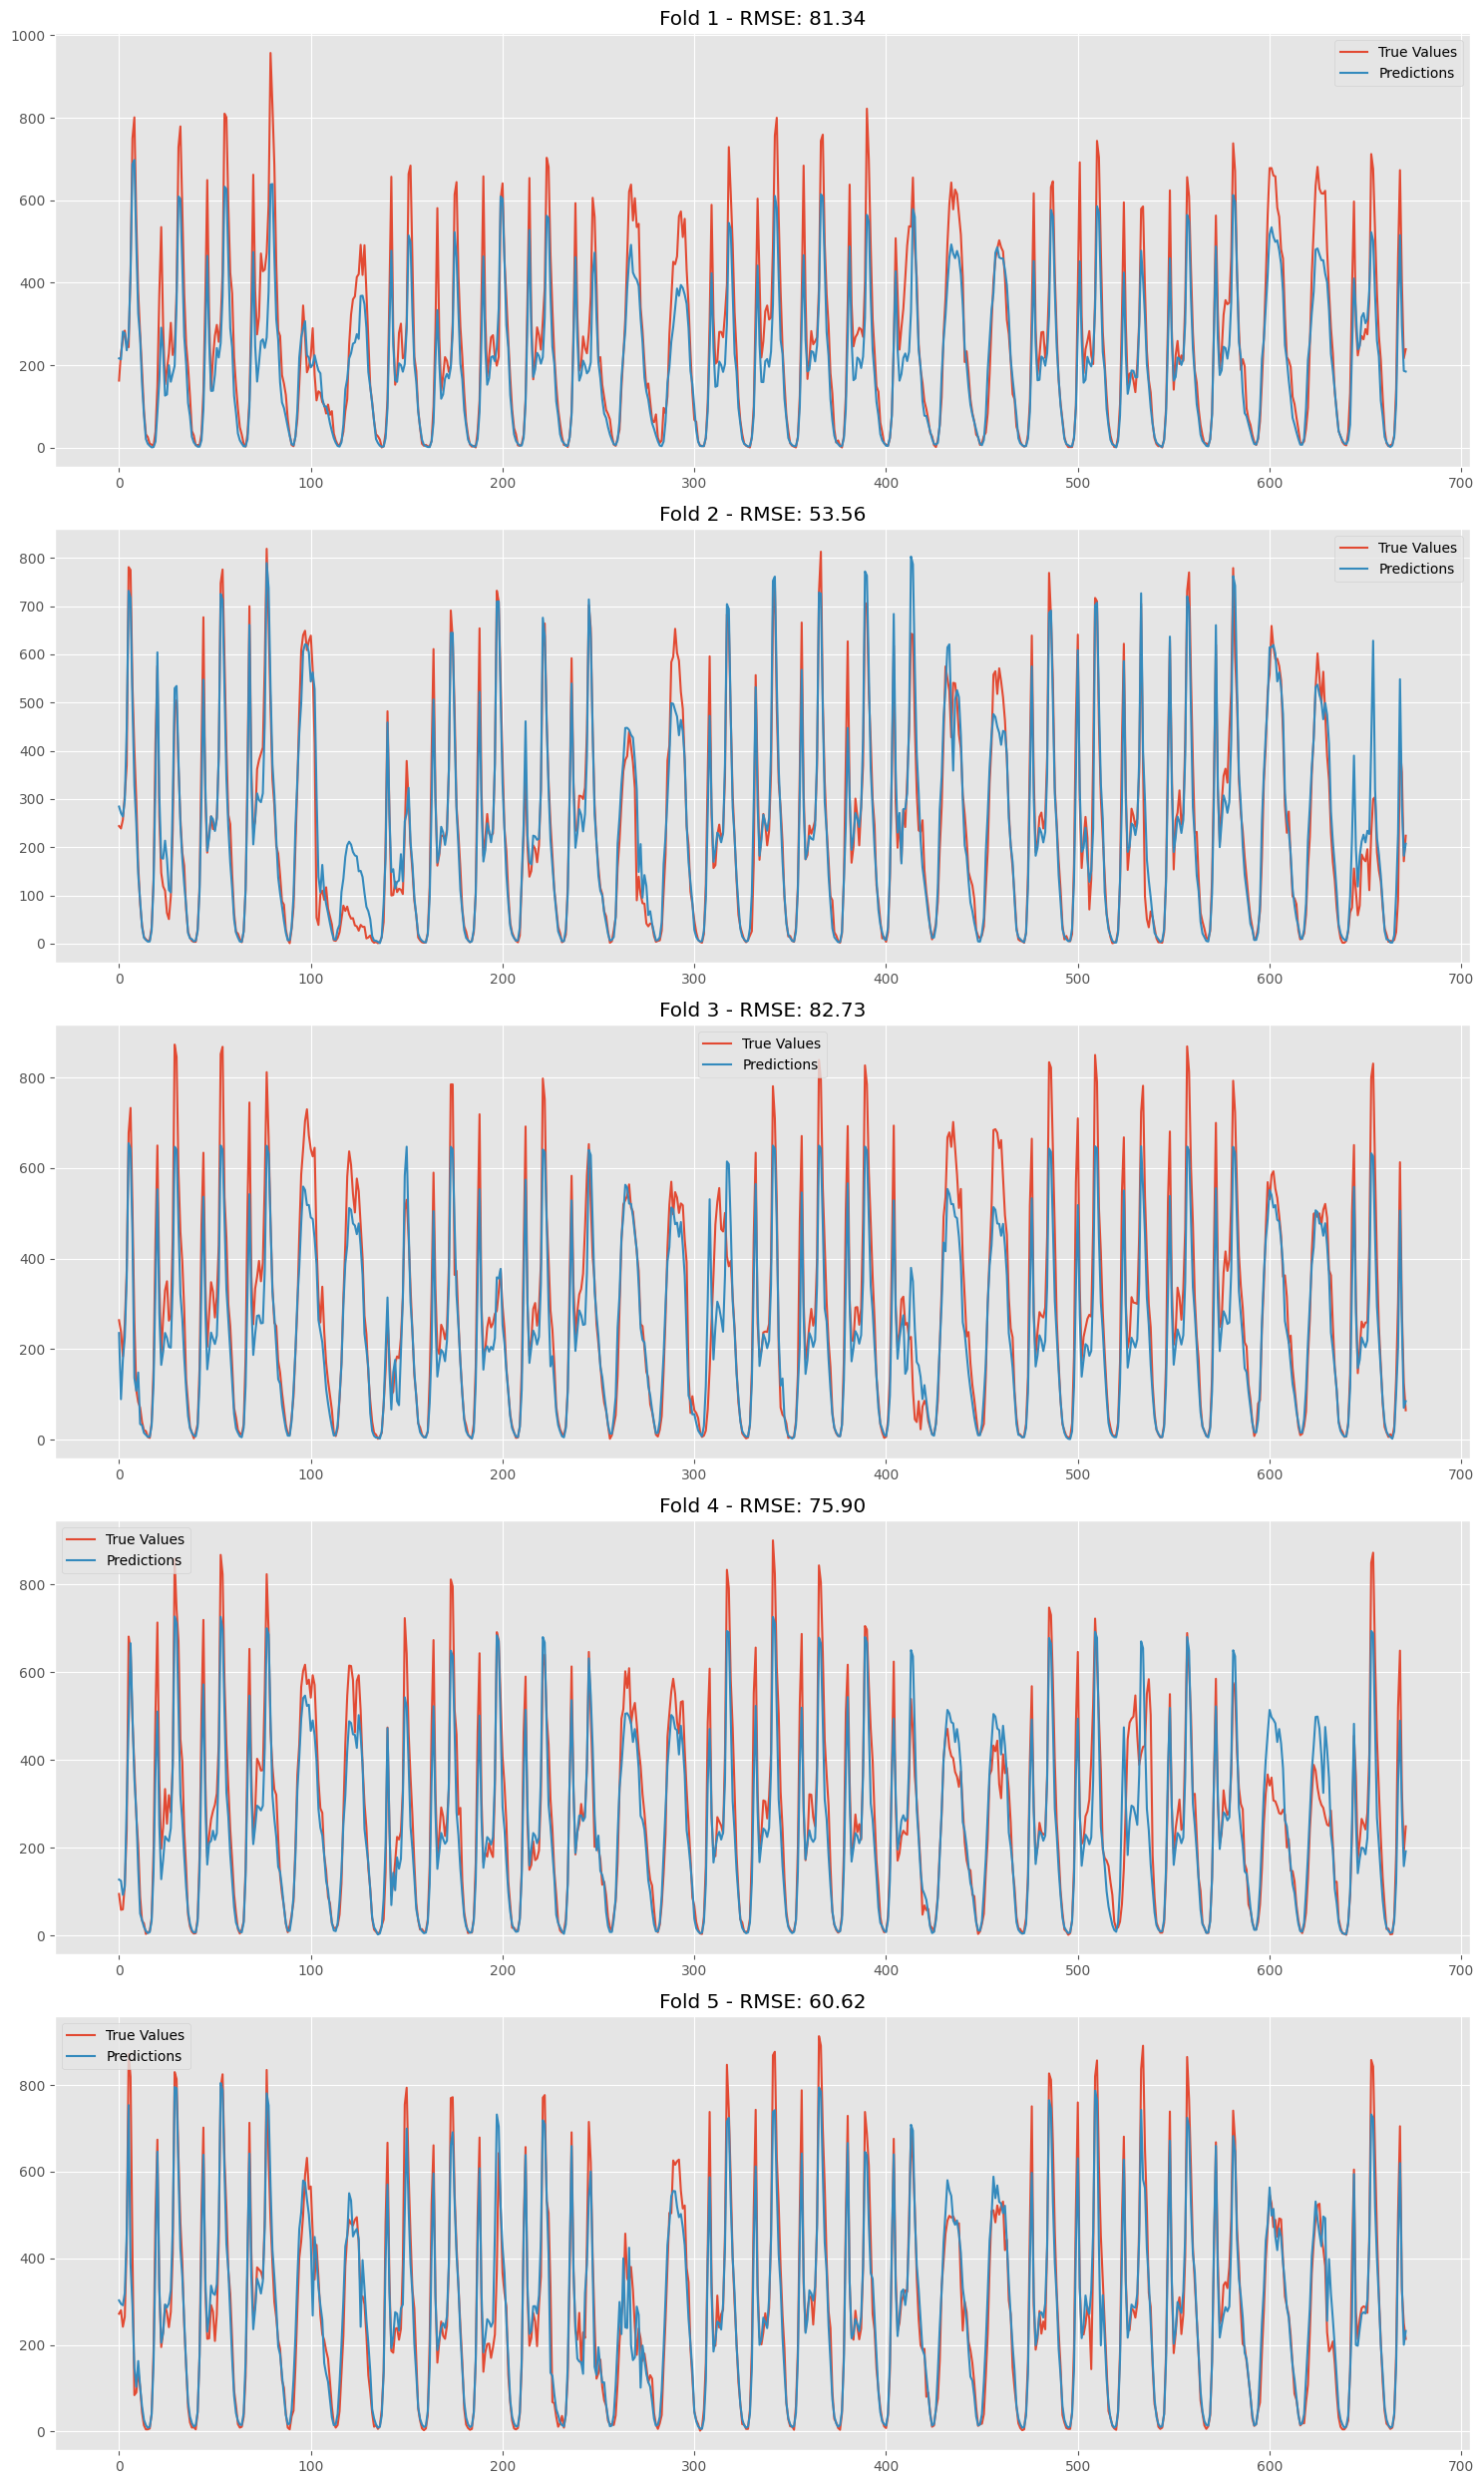

Average RMSE across folds: 70.83


In [8]:
best_params = study.best_params

hour_processed_train_size_df = hour_processed_df.sort_values('timestamp').iloc[:int(len(hour_processed_df) * 0.8)]

rmse_of_folds_list = []
fold_predictions = []
fold_true_values = []

fig, ax = plt.subplots(figsize=(10, 6))

for i, (train_idx, test_idx) in enumerate(tcsv.split(np.arange(len(hour_processed_train_size_df)))):
    ax.scatter(train_idx, [i] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
    ax.scatter(test_idx, [i] * len(test_idx), color="red", label="Test" if i == 0 else "", s=10)

    full_idx = np.concatenate((train_idx, test_idx))

    fold_df = hour_processed_train_size_df.iloc[full_idx]

    train_split, val_split = processor.split_and_engineer_data(fold_df)

    y_train_split = train_split['count']
    X_train_split = train_split[features_from_rfe_selection]

    y_val_split = val_split['count']
    X_val_split = val_split[features_from_rfe_selection]

    lgbm_regressor = lgb.LGBMRegressor(**best_params, verbose=-1)

    transformed_regressor = TransformedTargetRegressor(
        regressor=lgbm_regressor,
        func=func,
        inverse_func=inverse_func
    )

    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', transformed_regressor)
    ])

    pipe.fit(X_train_split, y_train_split)

    y_pred = pipe.predict(X_val_split)

    fold_predictions.append(y_pred)
    fold_true_values.append(y_val_split.values)

    rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))

    rmse_of_folds_list.append(rmse)

ax.set_xlabel("Time Index")
ax.set_ylabel("Fold")
ax.set_title("Time Series Cross-Validation Splits")
ax.legend()
sns.despine()
plt.show()

# Plot the results for each fold
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, (y_pred, y_true) in enumerate(zip(fold_predictions, fold_true_values)):
    axes[i].plot(y_true, label='True Values')
    axes[i].plot(y_pred, label='Predictions')
    axes[i].set_title(f'Fold {i+1} - RMSE: {rmse_of_folds_list[i]:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

print(f"Average RMSE across folds: {np.mean(rmse_of_folds_list):.2f}")


Validation RMSE: 61.6097548515611


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lawrence\AppData\Local\Temp\ipykernel_29336\2257259008.py:26: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

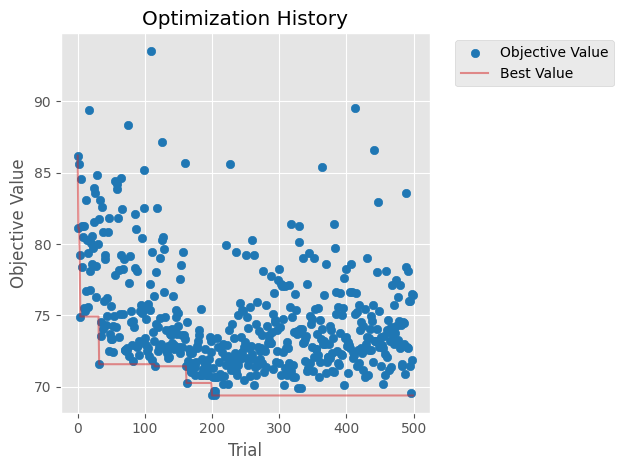

C:\Users\Lawrence\AppData\Local\Temp\ipykernel_29336\2257259008.py:32: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1000x600 with 0 Axes>

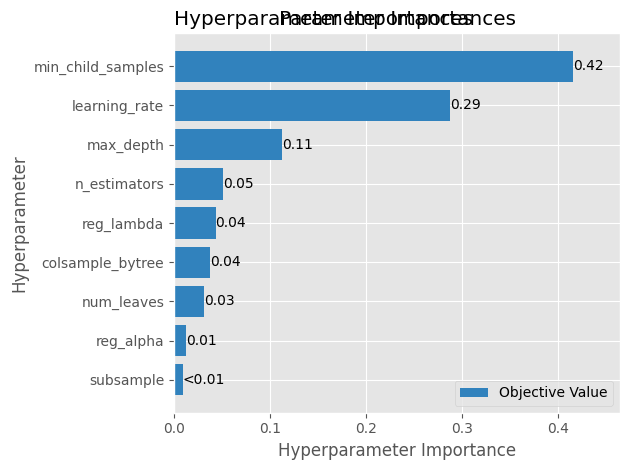

In [9]:
best_params = study.best_params
best_lgbm = lgb.LGBMRegressor(**best_params)

best_regr = TransformedTargetRegressor(
    regressor=best_lgbm,
    func=func,
    inverse_func=inverse_func
)

best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_regr)
])

best_pipeline.fit(X_train, y_train)

val_X = val_df[features]
val_y = val_df[target]

val_predictions = best_pipeline.predict(val_X)
val_rmse = np.sqrt(mean_squared_error(val_y, val_predictions))

print(f"Validation RMSE: {val_rmse}")

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importances")
plt.tight_layout()
plt.show()

C:\Users\Lawrence\AppData\Local\Temp\ipykernel_29336\2375574420.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<Axes: xlabel='colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='max_depth'>,
       <Axes: xlabel='min_child_samples'>, <Axes: xlabel='n_estimators'>,
       <Axes: xlabel='num_leaves'>, <Axes: xlabel='reg_alpha'>,
       <Axes: xlabel='reg_lambda'>, <Axes: xlabel='subsample'>],
      dtype=object)

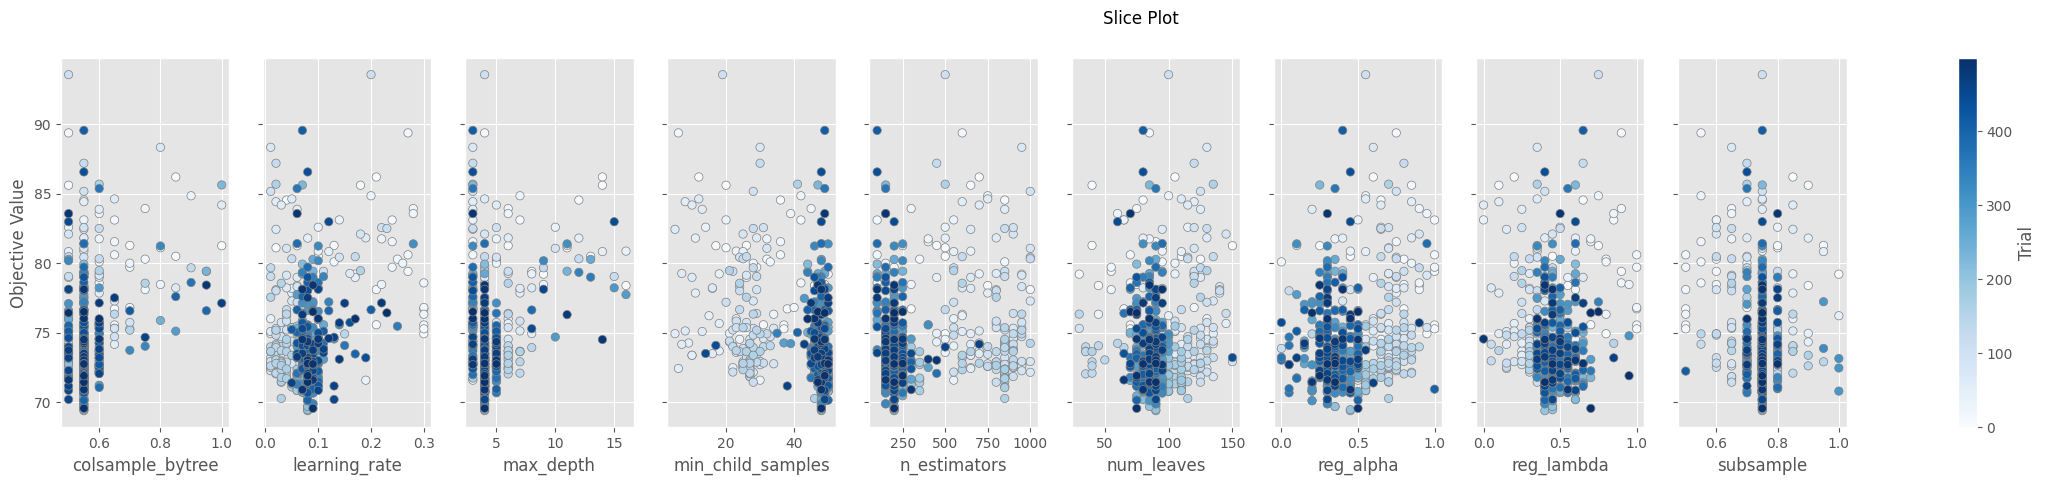

In [10]:
optuna.visualization.matplotlib.plot_slice(study)